In [43]:
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 16,          # Base font size
})

In [22]:
def read_file(name):

    with open(name, "r") as f:
        lines = f.readlines()

    return lines

# FePt

##### __Experimental lattice parameters__
```text
a = b = 3.86 Å
c = 3.76 Å
```
##### __Lattice vectors__
```text
1.00000000	0.00000000	0.00000000
0.00000000	1.00000000	0.00000000
0.00000000	0.00000000	0.97409326
```

##### __Atomic positions__
```text
        0.00000000      0.50000000      0.48704663
        0.50000000      0.00000000      0.48704663
        0.00000000      0.00000000      0.00000000
        0.50000000      0.50000000      0.00000000
```

# Functions to create EMTO input files

In [4]:
def create_kstr_input(
    filename,
    job_name,
    DMAX,
    LAT,
    NL,
    NQ3,
    A, B, C,
    lattice_vectors,
    lattice_positions,
):
    """
    Create a KSTR input file for EMTO.

    Parameters
    ----------
    filename : str
        Name of the output .smx file (e.g., 'fept.smx').
    job_name : str
        The JOBNAM (e.g., 'fept').
    NL : int
        Number of layers.
    NQ3 : int
        Value for NQ3 parameter.
    A, B, C : float
        Lattice constants.
    lattice_vectors : list[list[float]]
        3x3 matrix for lattice vectors.
    lattice_positions : list[list[float]]
        List of atomic positions.
    """

    template = f"""KSTR      HP......=N                               xx xxx xx
JOBNAM...={job_name:<10} MSGL.=  1 MODE...=B STORE..=Y HIGH...=Y
DIR001=./
DIR006=
Slope and Madelung matrices
NL.....= {NL:>1} NLH...= 9 NLW...= 9 NDER..= 6 ITRANS= 3 NPRN..= 1
(K*W)^2..=   0.00000 DMAX....=    {DMAX:>6} RWATS...=      0.10
NQ3...= {NQ3:>2} LAT...= {LAT:>1} IPRIM.= 0 NGHBP.=13 NQR2..= 0        80
A........= {A:.7f} B.......= {B:.7f} C.......={C:.8f}
"""

    # Add lattice vectors
    for vec in lattice_vectors:
        template += f"{vec[0]:.8f}\t{vec[1]:.8f}\t{vec[2]:.8f}\n"

    # Add lattice positions
    for pos in lattice_positions:
        template += f"\t{pos[0]:.8f}\t{pos[1]:.8f}\t{pos[2]:.8f}\n"

    # Append fixed section
    for i in range(NQ3):
        template += f"a/w......= 0.70 0.70 0.70 0.70\n"

    template += f"""NL_mdl.= {2*NL + 1}
LAMDA....=    2.5000 AMAX....=    4.5000 BMAX....=    4.5000
"""
    
    with open(filename, "w") as f:
        f.write(template)

    print(f"KSTR input file '{filename}' created successfully.")

In [5]:
def create_shape_input(
    filename,
    job_name,
    smx_file,
    NQ3,
):
    """
    Create a SHAPE input file for EMTO.

    Parameters
    ----------
    filename : str
        Name of the output SHAPE file (e.g., 'fept.dat').
    job_name : str
        The JOBNAM (e.g., 'fept').
    smx_file : str
        Path to the .tfh file (e.g., '../smx/fept.tfh').
    NQ3 : int
        Number of atoms (determines number of ASR lines).
    """

    template = f"""SHAPE     HP......=N
JOBNAM...={job_name:<10} MSGL.=  1
FOR001={smx_file}
DIR002=./
DIR006=./
Lmax..= 30 NSR..=129 NFI..= 11
NPRN..=  0 IVEF.=  3
****** Relative atomic sphere radii ASR(1:NQ) ******
"""

    # Add ASR lines based on NQ3
    for i in range(1, NQ3 + 1):
        template += f"ASR({i}).= 1.0\n"

    with open(filename, "w") as f:
        f.write(template)

    print(f"SHAPE input file '{filename}' created successfully.")

In [6]:
def create_kgrn_input(
    filename,
    job_name,
    smx_tfh_file,
    smx_mdl_file,
    shp_file,
):
    """
    Create a KGRN (self-consistent KKR) input file for EMTO.

    Parameters
    ----------
    filename : str
        Name of the output file (e.g., 'fept_kstr.dat').
    job_name : str
        The job name (e.g., 'fept').
    smx_tfh_file : str
        Path to the .tfh file (e.g., './smx/fept.tfh').
    smx_mdl_file : str
        Path to the .mdl file (e.g., './smx/fept.mdl').
    shp_file : str
        Path to the .shp file (e.g., './shp/fept.shp').
    atoms_info : list of dict
        List of atom information dictionaries with keys:
        'symbol', 'IQ', 'IT', 'ITA', 'NRM', 'conc', 'a_scr', 'b_scr',
        'theta', 'phi', 'FXM', 'm_split'
    """

    template = f"""KGRN      HP..= 0   !                              xx xxx xx
JOBNAM...={job_name}
MSGL.=1 STRT.=A FUNC.=SCA EXPAN=1 FCD.=Y GPM.=N FSM.=N
FOR001={smx_tfh_file}
FOR002={smx_mdl_file}
DIR003=./pot/
DIR006=
DIR010=./chd/
DIR011=./tmp
DIR021={job_name}.gpm.dat
DIR022={shp_file}
FOR098=/home/x_pamca/postdoc_proj/emto/jij_EMTO/kgrn_new2020/ATOM.cfg
Self-consistent KKR calculation 
**********************************************************************
SCFP:  information for self-consistency procedure:                   *
**********************************************************************
NITER.= 99 NLIN.= 31 NCPA.=  7 NPRN....=000000000
FRC...=  N DOS..=  Y OPS..=  N AFM..=  F CRT..=  M STMP..= A
Lmaxh.=  8 Lmaxt=  4 NFI..= 31 FIXG.=  2 SHF..=  0 SOFC.=  Y
KMSH...= S IBZ..=  5 NKX..= 12 NKY..= 12 NKZ..= 12 FBZ..=  N
ZMSH...= E NZ1..= 16 NZ2..= 16 NZ3..= 16 NRES.=  4 NZD..=999
DEPTH..=  1.100 IMAGZ.=  0.005 EPS...=  0.200 ELIM..= -1.000
AMIX...=  0.010 VMIX..=   0.70 EFMIX.=  0.900 VMTZ..=  0.000
TOLE...= 1.d-07 TOLEF.= 1.d-06 TOLCPA= 1.d-06 TFERMI=  300.0 (K)
SWS....= 2.8267 MMOM..=  0.000
EFGS...=  0.000 HX....=  0.101 NX...=  5 NZ0..= 16 KPOLE=  0
**********************************************************************
Sort:  information for alloy:                                        *
******************************SS-screeining*|***Magnetic structure ***
Symb  IQ  IT ITA NRM  CONC      a_scr b_scr |Teta    Phi    FXM  m(split)
Pt     1   1   1   1  1.000000  0.750 1.100  0.0000  0.0000  N   0.4000
Pt     2   1   1   1  1.000000  0.750 1.100  0.0000  0.0000  N   0.4000
Fe     3   2   1   1  1.000000  0.750 1.100  0.0000  0.0000  N   2.0000
Fe     4   2   1   1  1.000000  0.750 1.100  0.0000  0.0000  N   2.0000
**********************************************************************
Spin-spiral wave vector:
qx....= 0.000000 qy....= 0.000000 qz....= 0.000000
**********************************************************************
Atom:  information for atomic calculation:                           *
**********************************************************************
IEX...=  4 NES..= 15 NITER= 50 IWAT.=  0 NPRNA=  0
VMIXATM..=  0.300000 RWAT....=  3.500000 RMAX....= 20.000000
DX.......=  0.030000 DR1.....=  0.001000 TEST....=  1.00E-12
TESTE....=  1.00E-07 TESTY...=  1.00E-08 TESTV...=  1.00E-07
"""

    with open(filename, "w") as f:
        f.write(template)

    print(f"KGRN input file '{filename}' created successfully.")

In [7]:
def create_kfcd_input(
    filename,
    job_name,
    shp_file
):
    """
    Create a KFCD input file for EMTO.

    Parameters
    ----------
    filename : str
        Name of the output SHAPE file (e.g., 'fept.dat').
    job_name : str
        The JOBNAM (e.g., 'fept').
    shp_file : str
        Path to the .tfh file (e.g., '../shp/fept.shp').
    """

    template = f"""KFCD      HP......=N sno..=100                     xx xxx xx
JOBNAM...={job_name:<10}                         MSGL.=  1
STRNAM...={job_name}
DIR001=../smx/
DIR002=../chd/
FOR003={shp_file}
DIR004=../smx/
DIR006=
Lmaxs.= 30 NTH..= 41 NFI..= 81
OVCOR.=  Y UBG..=  N NPRN.=  0 NRM..=  0
"""

    with open(filename, "w") as f:
        f.write(template)

    print(f"KFCD input file '{filename}' created successfully.")

In [20]:
def create_job(
    folder,
    filename
):
    """
    Create a KFCD input file for EMTO.

    Parameters
    ----------
    filename : str
        Name of the output SHAPE file (e.g., 'fept.dat').
    job_name : str
        The JOBNAM (e.g., 'fept').
    shp_file : str
        Path to the .tfh file (e.g., '../shp/fept.shp').
    """

    template = f"""#! /bin/bash -l
#SBATCH -A naiss2025-1-38
#SBATCH --exclusive
#SBATCH -n 1
#SBATCH -t 00:30:00
#SBATCH -J fept_{folder}

echo "Running folder {folder}"
echo ""

cd smx

echo "Running KSTR:"
kstr.exe < fept_{folder}.dat > smx.log

if [ $? -ne 0 ]; then
    echo "KSTR failed!"
    exit 1
else
    echo "DONE!"
fi

echo "Info about DMAX:"
grep -A1 "Primv" smx.log

cd ../shp

echo "Running SHAPE:"
shape.exe < fept_{folder}.dat > shp.log

if [ $? -ne 0 ]; then
    echo "SHAPE failed!"
    exit 1
else
    echo "DONE!"
fi

cd ../

echo "Running KGRN:"
mpirun -n 1  kgrn_mpi.x < fept_{folder}.dat > kgrn.log

if [ $? -ne 0 ]; then
    echo "KGRN failed!"
    exit 1
else
    echo "DONE!"
fi

cd fcd/ 

echo "Running KFCD:"
kfcd.exe < fept_{folder}.dat > kfcd.log

if [ $? -ne 0 ]; then
    echo "KGRN failed!"
    exit 1
else
    echo "DONE!"
fi

cd ../

"""

    with open(filename, "w") as f:
        f.write(template)

    print(f"Script for job file '{filename}' created successfully.")

# Create input files for different c/a ratios

In [21]:
initial_ratio = 3.76 / 3.86
fractional_coors = np.array([[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.0, 0.0, 0.0], [0.5, 0.5, 0.0]])

ratios = np.linspace(initial_ratio - 3*0.02, initial_ratio + 3*0.02, 7)

# Subfolders to create inside each ratio folder
subfolders = ['smx', 'shp', 'pot', 'chd', 'fcd']

for i in ratios:

    ratio_folder = f"{i:.2f}"
    os.makedirs(ratio_folder, exist_ok=True)
    
    for subfolder in subfolders:
        subfolder_path = os.path.join(ratio_folder, subfolder)
        os.makedirs(subfolder_path, exist_ok=True)

    lattice_vectors =  np.array([[1.0,  0.0, 0.0], [0.0,  1.0, 0.0], [0.0,  0.0, i]])
    cart_coords = fractional_coors @ lattice_vectors

    create_kstr_input(
    filename=f"{i:.2f}/smx/fept_{i:.2f}.dat",
    job_name=f"fept_{i:.2f}",
    NL=3,
    NQ3=4,
    A=1.0,
    B=1.0,
    C=i,
    DMAX=1.8265,
    LAT=5,
    lattice_vectors=lattice_vectors,
    lattice_positions=cart_coords,
)
    create_shape_input(
    filename=f"{i:.2f}/shp/fept_{i:.2f}.dat",
    job_name=f"fept_{i:.2f}",
    smx_file=f"../smx/fept_{i:.2f}.tfh",
    NQ3=4,
)
    create_kgrn_input(
    filename=f"{i:.2f}/fept_{i:.2f}.dat",
    job_name=f"fept_{i:.2f}",
    smx_tfh_file=f"./smx/fept_{i:.2f}.tfh",
    smx_mdl_file=f"./smx/fept_{i:.2f}.mdl",
    shp_file=f"./shp/fept_{i:.2f}.shp",
)
    create_kfcd_input(
    filename=f"{i:.2f}/fcd/fept_{i:.2f}.dat",
    job_name=f"fept_{i:.2f}",
    shp_file=f"../shp/fept_{i:.2f}.shp",
)
    
    create_job(
    folder=f"{i:.2f}",
    filename=f"{i:.2f}/run_fept_{i:.2f}.sh",
)
    

KSTR input file '0.91/smx/fept_0.91.dat' created successfully.
SHAPE input file '0.91/shp/fept_0.91.dat' created successfully.
KGRN input file '0.91/fept_0.91.dat' created successfully.
KFCD input file '0.91/fcd/fept_0.91.dat' created successfully.
Script for job file '0.91/run_fept_0.91.sh' created successfully.
KSTR input file '0.93/smx/fept_0.93.dat' created successfully.
SHAPE input file '0.93/shp/fept_0.93.dat' created successfully.
KGRN input file '0.93/fept_0.93.dat' created successfully.
KFCD input file '0.93/fcd/fept_0.93.dat' created successfully.
Script for job file '0.93/run_fept_0.93.sh' created successfully.
KSTR input file '0.95/smx/fept_0.95.dat' created successfully.
SHAPE input file '0.95/shp/fept_0.95.dat' created successfully.
KGRN input file '0.95/fept_0.95.dat' created successfully.
KFCD input file '0.95/fcd/fept_0.95.dat' created successfully.
Script for job file '0.95/run_fept_0.95.sh' created successfully.
KSTR input file '0.97/smx/fept_0.97.dat' created succes

# Parse energy results

In [36]:
initial_ratio = 3.76 / 3.86
ratios = np.linspace(initial_ratio - 3*0.02, initial_ratio + 3*0.02, 7)

energies_lda = []
energies_gga = []

for i in ratios:
    out = read_file(f"{i:.2f}/fcd/fept_{i:.2f}.prn")

    for line in out:
        if "TOT-LDA" in line:
            energies_lda.append(float(line.split()[1]))

        if "TOT-GGA" in line:
            energies_gga.append(float(line.split()[1]))

# Fitting equation of states

Equilibrium c/a for GGA = 0.9590
Minimum Energy for GGA= -78878.950763 eV
Equilibrium c/a for LDA = 0.9648
Minimum Energy for LDA= -78828.981174 eV


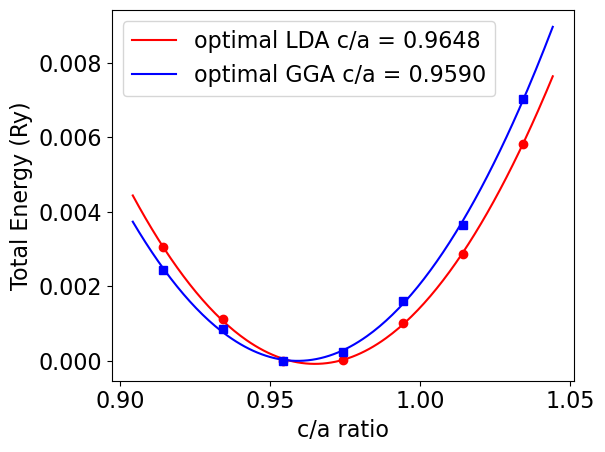

In [54]:
def compute_equilibrium_ca(ratios, energies):
    # Fit a quadratic polynomial: E = a*x^2 + b*x + c
    coeffs = np.polyfit(ratios, energies, 2)
    a, b, c = coeffs

    # Compute equilibrium c/a (minimum of parabola)
    ca_eq = -b / (2 * a)
    E_eq = np.polyval(coeffs, ca_eq)

    return ca_eq, E_eq, coeffs


# Fit a quadratic polynomial: E = a*x^2 + b*x + c
ca_eq_lda, ene_eq_lda, coeffs_lda  = compute_equilibrium_ca(ratios, energies_lda)
ca_eq_gga, ene_eq_gga, coeffs_gga = compute_equilibrium_ca(ratios, energies_gga)


print(f"Equilibrium c/a for GGA = {ca_eq_gga:.4f}")
print(f"Minimum Energy for GGA= {ene_eq_gga:.6f} eV")

print(f"Equilibrium c/a for LDA = {ca_eq_lda:.4f}")
print(f"Minimum Energy for LDA= {ene_eq_lda:.6f} eV")


# Plot
xfit = np.linspace(ratios.min() - 0.01, ratios.max() + 0.01, 200)
efit_lda = np.polyval(coeffs_lda, xfit)
efit_gga = np.polyval(coeffs_gga, xfit)

plt.plot(ratios, np.array(energies_lda)-min(energies_lda), 'or')
plt.plot(xfit, efit_lda - min(energies_lda), '-r', label='optimal LDA c/a = {:.4f}'.format(ca_eq_lda))
plt.plot(ratios, np.array(energies_gga)-min(energies_gga), 'sb')
plt.plot(xfit, efit_gga - min(energies_gga), '-b', label='optimal GGA c/a = {:.4f}'.format(ca_eq_gga))

plt.xlabel('c/a ratio')
plt.ylabel('Total Energy (Ry)')             
plt.legend()
plt.tight_layout()
plt.show()


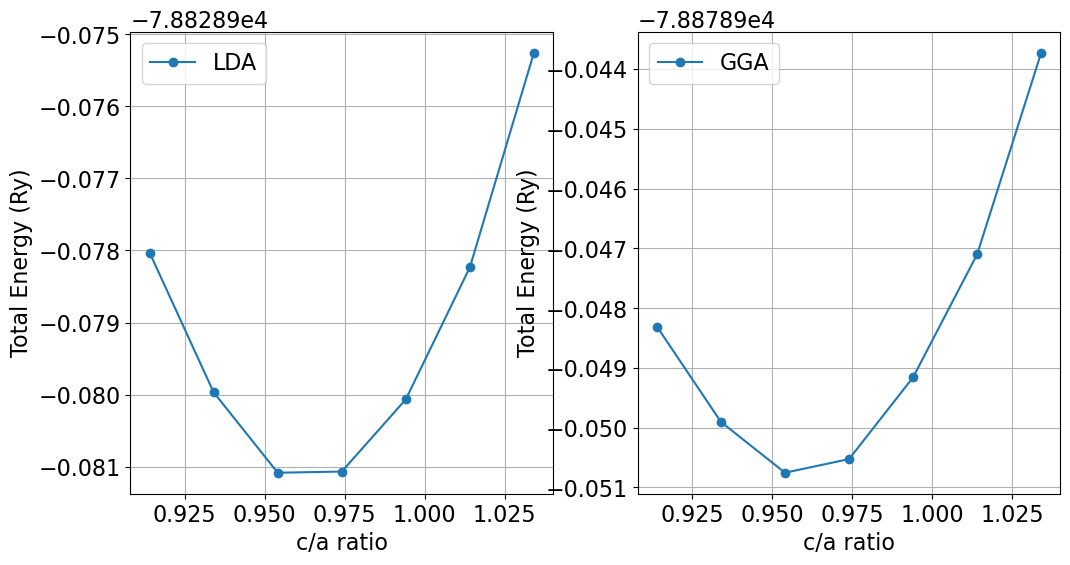

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # width=10, height=4 inches

ax1.plot(ratios, energies_lda, marker='o', label='LDA')
ax1.set_xlabel('c/a ratio')
ax1.set_ylabel('Total Energy (Ry)')
ax1.legend()
ax1.grid()

ax2.plot(ratios, energies_gga, marker='o', label='GGA')
ax2.set_xlabel('c/a ratio')
ax2.set_ylabel('Total Energy (Ry)')
ax2.legend()
ax2.grid()

plt.show()


In [35]:
energies_gga

[-78878.948308]